<a href="https://colab.research.google.com/github/BMM52/MovieLens-Dataset-Recommender-System/blob/main/%F0%9F%8E%AC_Lights%2C_Camera%2C_Recommend!_A_Hybrid_Approach_to_Movie_Suggestions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🎬 Lights, Camera, Recommend! A Hybrid Approach to Movie Suggestions
  
  This notebook provides a **concise, professional walkthrough** of building a **hybrid movie recommender system**
  using the [MovieLens dataset](https://grouplens.org/datasets/movielens/).
  Perform **data cleaning, merging, and exploratory data analysis (EDA)** to understand user–movie interactions.
  Build a **user-based collaborative filtering model** with **similarity shrinkage**—a technique inspired by
  **industry leaders like Netflix**—to reduce noise when users share only a few ratings.
  Add a **matrix factorization (SVD) fallback** for sparse situations.
  This hybrid strategy blends neighborhood and latent-factor methods to deliver **personalized, high-quality recommendations**.

Importing Essential Libraries

In [1]:
%pip install numpy==1.26.2

In [3]:
%pip install surprise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing the dataset

In [3]:
# Download and unzip the dataset
!wget http://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

--2025-09-12 11:08:32--  http://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-25m.zip [following]
--2025-09-12 11:08:32--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip.5’

ml-25m.zip.5        100%[===================>] 249.84M  56.0MB/s    in 4.6s    

2025-09-12 11:08:37 (54.6 MB/s) - ‘ml-25m.zip.5’ saved [261978986/261978986]

Archive:  ml-25m.zip
replace ml-25m/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Data Scrubbing

In [4]:
movies = pd.read_csv('/content/ml-25m/movies.csv')
ratings = pd.read_csv('/content/ml-25m/ratings.csv',nrows = 1_000_000)

tags = pd.read_csv('/content/ml-25m/tags.csv')

In [5]:
movies.shape

(62423, 3)

In [6]:
ratings.shape

(1000000, 4)

In [7]:
tags.shape

(1093360, 4)

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1000000 non-null  int64  
 1   movieId    1000000 non-null  int64  
 2   rating     1000000 non-null  float64
 3   timestamp  1000000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 30.5 MB


In [10]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [11]:
ratings.describe()

,userId,movieId,rating,timestamp
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,3414.023267,21108.987256,3.532902,1.208299e+09
std,1924.322666,39075.605217,1.057824,2.305411e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,1751.000000,1136.000000,3.000000,9.968151e+08
50%,3445.000000,2826.000000,3.500000,1.183782e+09
75%,5108.000000,8370.000000,4.000000,1.446418e+09
max,6747.000000,208939.000000,5.000000,1.574288e+09


In [12]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [14]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [15]:
df = movies.merge(ratings , on = 'movieId')
dfs = df.groupby('movieId').agg({'rating':['mean','count']})
dfs.columns=['Rating','review_count']
df1 = df.merge(dfs,on='movieId')
df1.set_index('movieId',inplace = True)
df1['Rating'] = df1['Rating'].round(1)
df1.rename(columns = {'Rating':'avg_rating'},inplace = True)

### Exploratory Data Analysis (EDA)

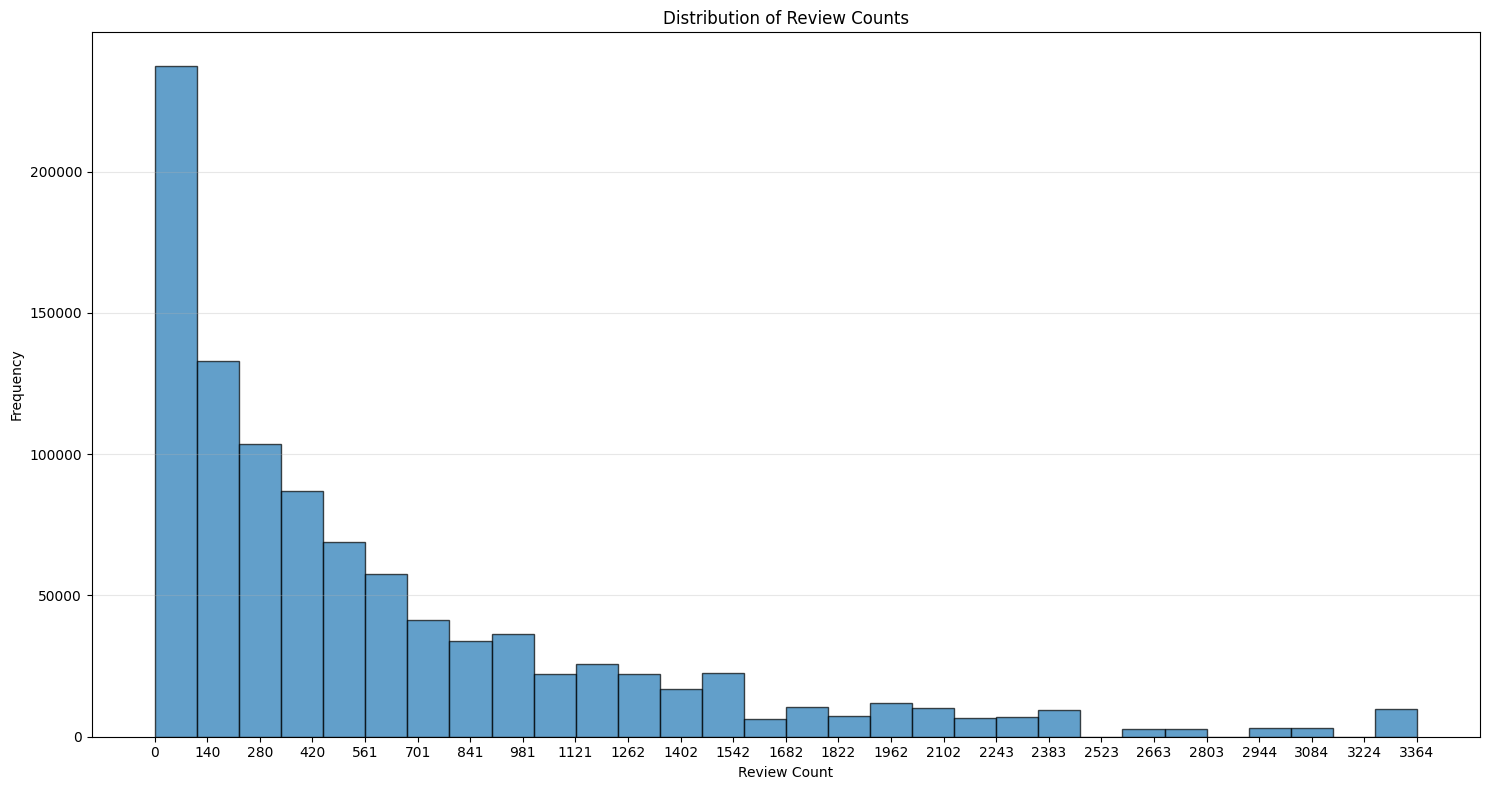

In [16]:
plt.figure(figsize=(15, 8))
plt.hist(df1['review_count'], bins=30, edgecolor='black', alpha=0.7)

plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Counts')

# Set exactly 15 tick markers on x-axis
max_value = df1['review_count'].max()
plt.xticks(np.linspace(0, max_value, 25))  # 15 evenly spaced markers

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
tags

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455
...,...,...,...,...
1093355,162521,66934,Neil Patrick Harris,1427311611
1093356,162521,103341,cornetto trilogy,1427311259
1093357,162534,189169,comedy,1527518175
1093358,162534,189169,disabled,1527518181


In [18]:
tags_df = tags.groupby(['movieId','userId'])['tag'].apply(list).reset_index()

In [19]:
df1_merged = df1.merge(tags_df, on=['movieId', 'userId'], how='left')

In [20]:
df1_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   movieId       1000000 non-null  int64  
 1   title         1000000 non-null  object 
 2   genres        1000000 non-null  object 
 3   userId        1000000 non-null  int64  
 4   rating        1000000 non-null  float64
 5   timestamp     1000000 non-null  int64  
 6   avg_rating    1000000 non-null  float64
 7   review_count  1000000 non-null  int64  
 8   tag           11332 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 68.7+ MB


In [21]:
df1_merged[df1_merged['tag'].notnull()]

,movieId,title,genres,userId,rating,timestamp,avg_rating,review_count,tag
258,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,791,4.5,1515175489,3.9,2358,[Owned]
464,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1361,2.5,1216145696,3.9,2358,[Pixar]
1084,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3164,5.0,1223264174,3.9,2358,"[Pixar, time travel]"
1168,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3448,3.0,1492776058,3.9,2358,"[children, comedy, funny, witty]"
1618,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4676,4.0,1207675658,3.9,2358,[rated-G]
...,...,...,...,...,...,...,...,...,...
999940,205435,On Ice (1935),Animation,6550,3.0,1566862879,3.0,1,"[Disney, mickey mouse]"
999952,206068,Hoax (2019),Horror,6550,1.5,1567969203,1.5,1,[bigfoot]
999966,206700,Hex (2019),Horror|Thriller,6550,3.0,1569305481,3.0,1,"[cambodia, magic, witch]"
999968,206727,Jeff Dunham: Beside Himself (2019),Comedy,2403,3.0,1570056088,3.0,1,"[bad language, political, racist humor, sexist..."


In [22]:
df1_merged['tag'] = df1_merged['tag'].fillna("")

In [23]:
tag_users = df1_merged[df1_merged['tag'].notnull()]['userId'].nunique()
print("Users who used tags:", tag_users,"out of",df1_merged['userId'].nunique())
tag_movies = df1_merged[df1_merged['tag'].notnull()]['movieId'].nunique()
print("Movies with tags:", tag_movies,"out of",df1_merged['movieId'].nunique())

Users who used tags: 6747 out of 6747
Movies with tags: 21952 out of 21952


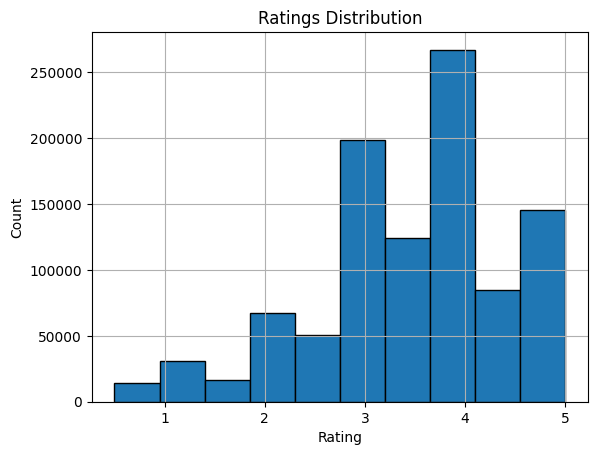

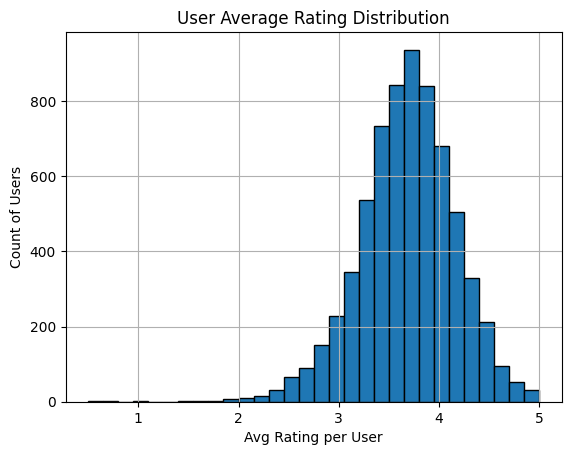

In [24]:
# Histogram of ratings
df1_merged['rating'].hist(bins=10, edgecolor='black')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Avg ratings per user
user_avg = df1_merged.groupby('userId')['rating'].mean()
user_avg.hist(bins=30, edgecolor='black')
plt.title("User Average Rating Distribution")
plt.xlabel("Avg Rating per User")
plt.ylabel("Count of Users")
plt.show()

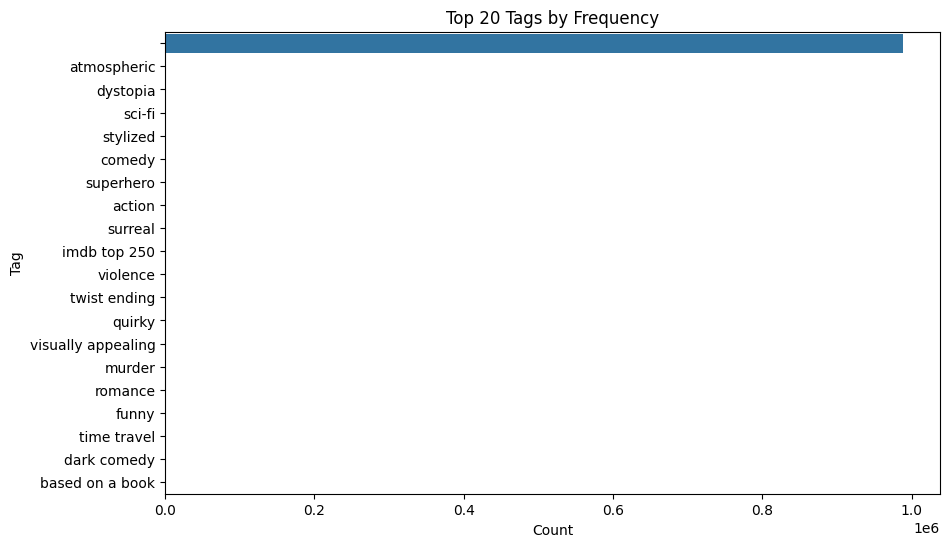

In [25]:
tags_only = df1_merged.dropna(subset=["tag"])  # remove rows with null tags

# Flatten tag list into individual tags
all_tags = tags_only['tag'].explode()

top_tags = all_tags.value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_tags.values, y=top_tags.index)
plt.title("Top 20 Tags by Frequency")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()


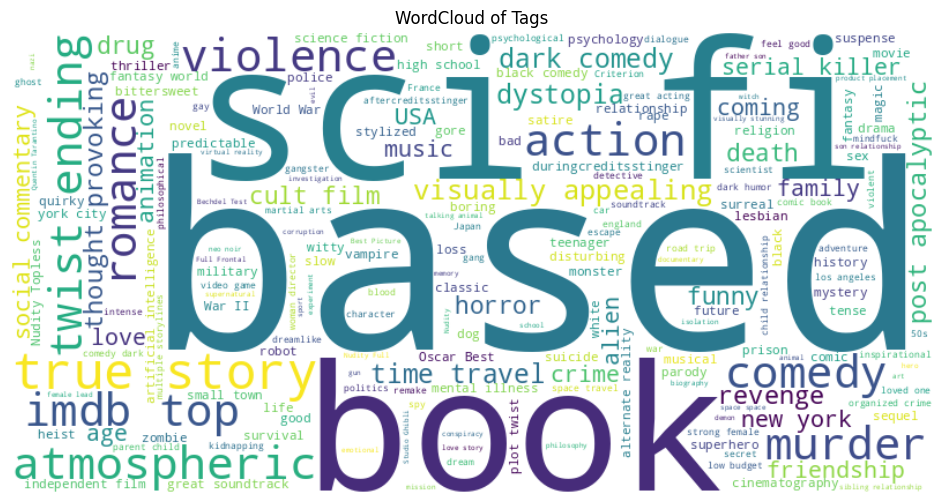

In [26]:
from wordcloud import WordCloud

tags_only = df1_merged.dropna(subset=["tag"])
all_tags = tags_only['tag'].explode()

text = " ".join(all_tags)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Tags")
plt.show()


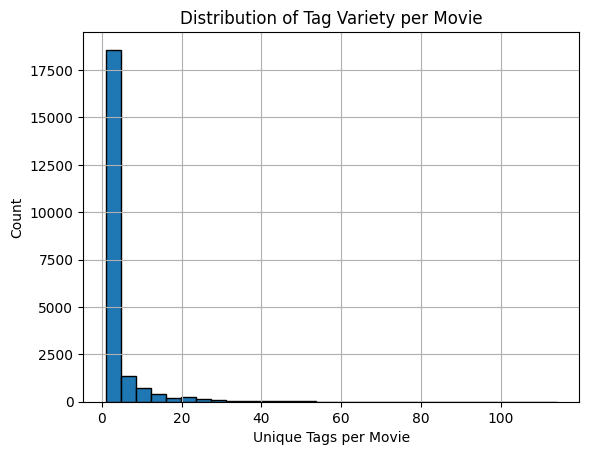

movieId
260       114
296        93
79132      80
109487     79
356        76
48394      74
2571       71
2959       66
7361       65
4878       65
Name: tag, dtype: int64


In [27]:
# How many unique tags per movie
movie_tag_counts = df1_merged.groupby('movieId')['tag'].apply(lambda x: x.dropna().explode().nunique())
movie_tag_counts.hist(bins=30, edgecolor='black')
plt.title("Distribution of Tag Variety per Movie")
plt.xlabel("Unique Tags per Movie")
plt.ylabel("Count")
plt.show()

# Which movies have the richest tags
rich_tagged_movies = movie_tag_counts.sort_values(ascending=False).head(10)
print(rich_tagged_movies)

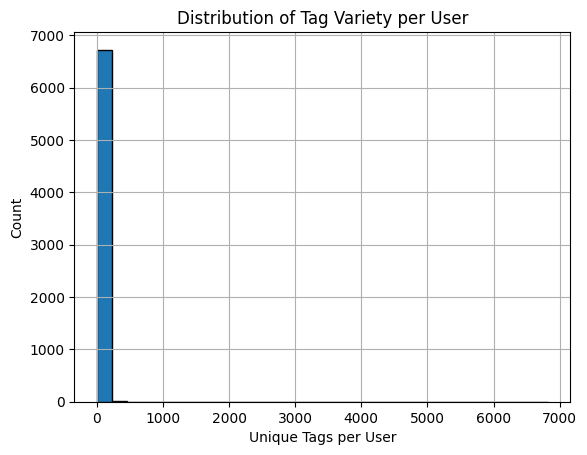

userId
6550    6822
3448    1570
3394    1322
4429     931
6038     808
3225     688
3975     577
5196     475
871      472
5572     466
Name: tag, dtype: int64


In [28]:
# Tags per user
user_tag_counts = df1_merged.groupby('userId')['tag'].apply(lambda x: x.dropna().explode().nunique())
user_tag_counts.hist(bins=30, edgecolor='black')
plt.title("Distribution of Tag Variety per User")
plt.xlabel("Unique Tags per User")
plt.ylabel("Count")
plt.show()

# Top tagging users
top_tagging_users = user_tag_counts.sort_values(ascending=False).head(10)
print(top_tagging_users)


             tag    userId
tag     1.000000  0.674443
userId  0.674443  1.000000


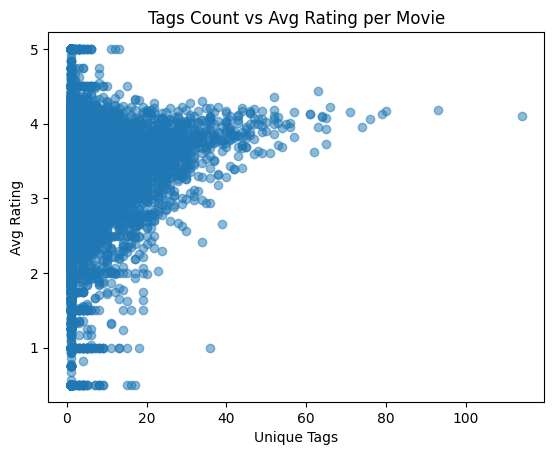

In [29]:
# Does more tags mean more reviews?
tag_review_corr = df1_merged.groupby('movieId').agg({
    'tag': lambda x: x.dropna().explode().nunique(),
    'userId': 'count'
}).corr()
print(tag_review_corr)

# Scatter plot
agg_df = df1_merged.groupby('movieId').agg(
    tags_count = ('tag', lambda x: x.dropna().explode().nunique()),
    reviews_count = ('userId','count'),
    avg_rating = ('rating','mean')
).reset_index()

plt.scatter(agg_df['tags_count'], agg_df['avg_rating'], alpha=0.5)
plt.title("Tags Count vs Avg Rating per Movie")
plt.xlabel("Unique Tags")
plt.ylabel("Avg Rating")
plt.show()


In [30]:
df1.drop(['rating','userId','timestamp'],axis = 1, inplace = True)

In [31]:
df1.drop_duplicates(inplace = True)

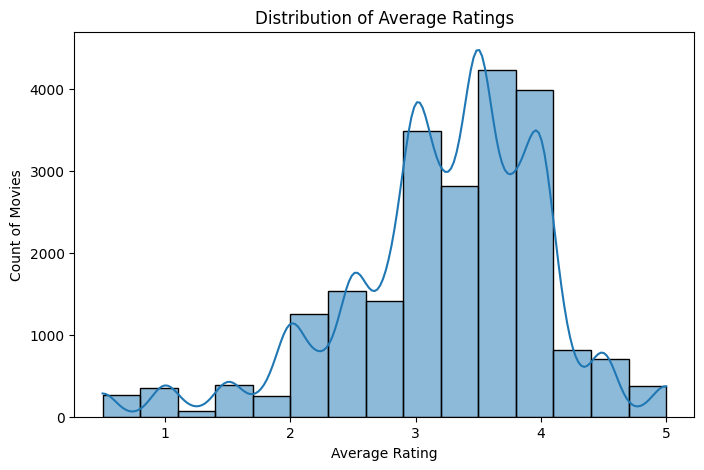

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(df1['avg_rating'], bins=15, kde=True)
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count of Movies")
plt.show()

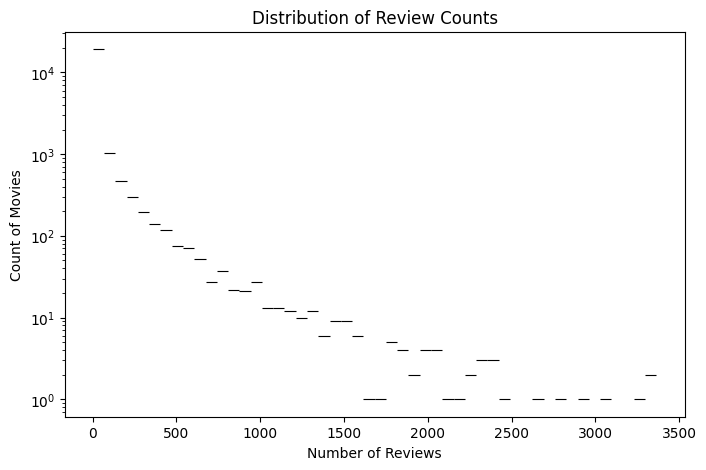

In [33]:
plt.figure(figsize=(8,5))
sns.histplot(df1['review_count'], bins=50, log_scale=(False, True))  # log scale for skewness
plt.title("Distribution of Review Counts")
plt.xlabel("Number of Reviews")
plt.ylabel("Count of Movies")
plt.show()

/tmp/ipython-input-2706278132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_reviewed, x='review_count', y='title', palette="viridis")


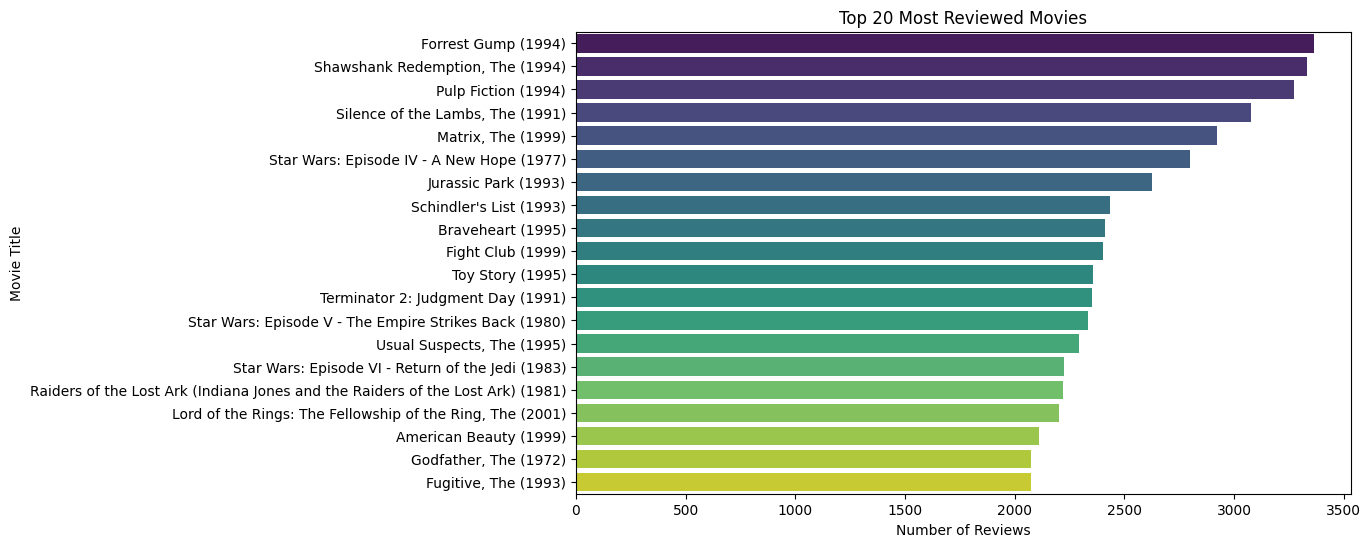

In [34]:
top_reviewed = df1.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_reviewed, x='review_count', y='title', palette="viridis")
plt.title("Top 20 Most Reviewed Movies")
plt.xlabel("Number of Reviews")
plt.ylabel("Movie Title")
plt.show()

/tmp/ipython-input-5894949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rated, x='avg_rating', y='title', palette="viridis")


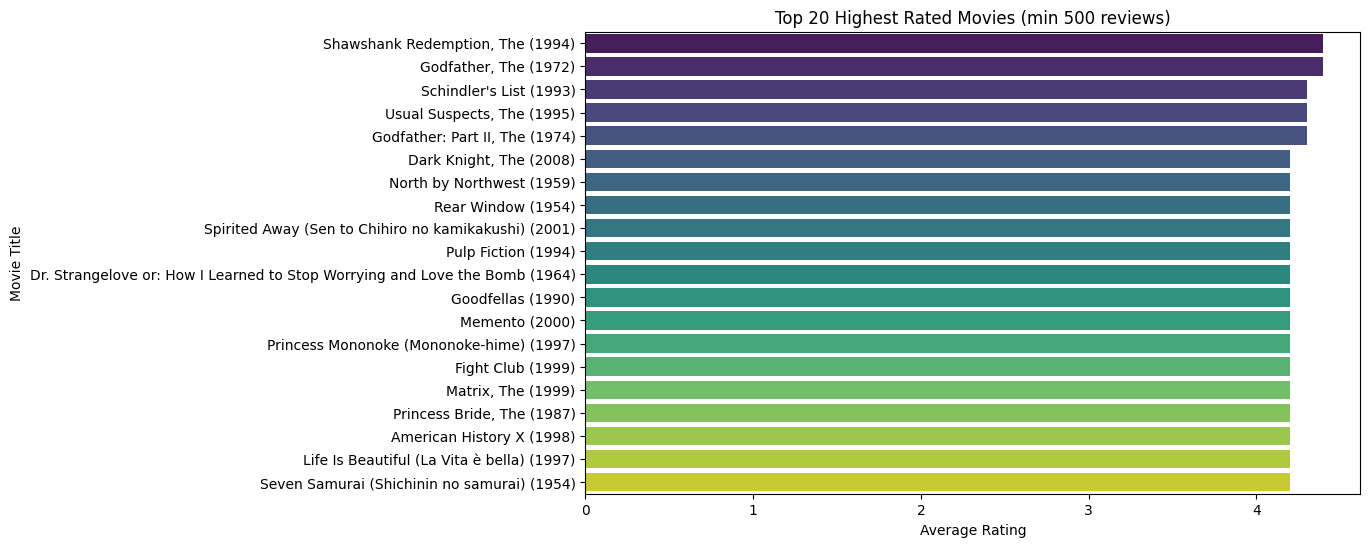

In [35]:
top_rated = df1[df1['review_count'] >= 500] \
                .sort_values('avg_rating', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_rated, x='avg_rating', y='title', palette="viridis")
plt.title("Top 20 Highest Rated Movies (min 500 reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()


/tmp/ipython-input-1443105972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rated, x='avg_rating', y='title', palette="coolwarm")


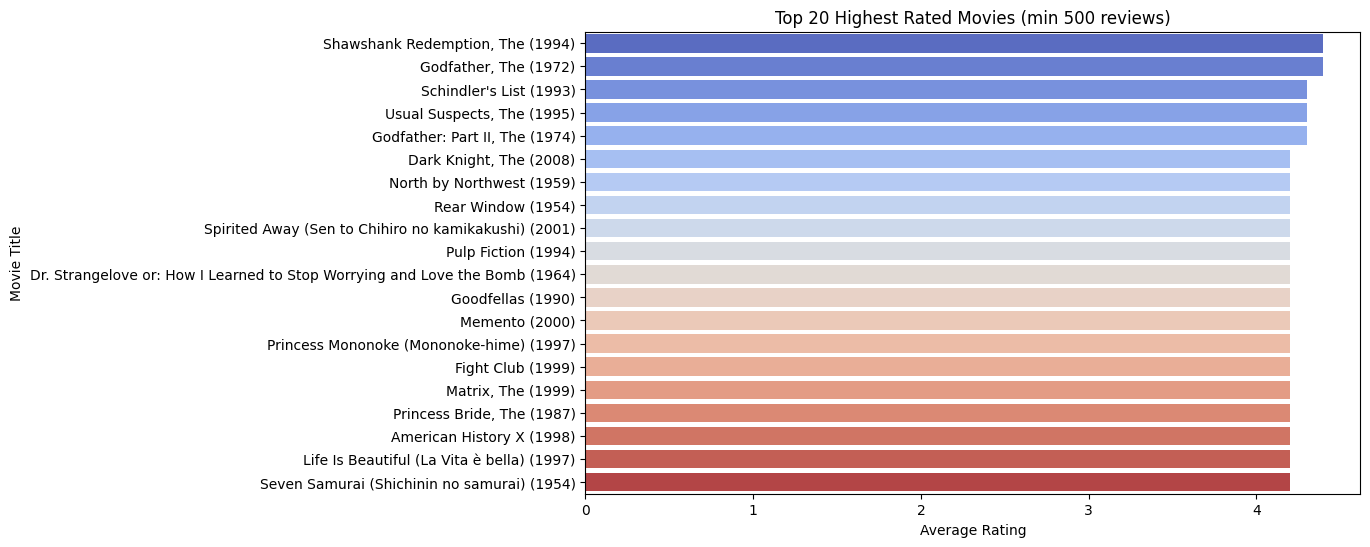

In [36]:
top_rated = df1[df1['review_count'] >= 500].sort_values('avg_rating', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_rated, x='avg_rating', y='title', palette="coolwarm")
plt.title("Top 20 Highest Rated Movies (min 500 reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()


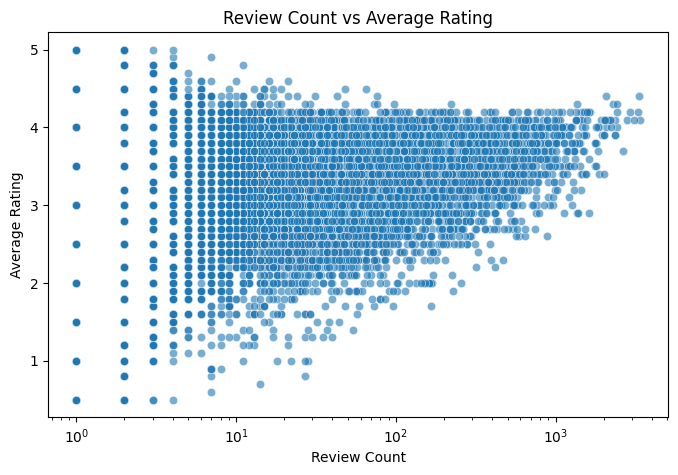

In [37]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df1, x='review_count', y='avg_rating', alpha=0.6)
plt.title("Review Count vs Average Rating")
plt.xlabel("Review Count")
plt.ylabel("Average Rating")
plt.xscale("log")  # review counts are usually very skewed
plt.show()

/tmp/ipython-input-4004211260.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_stats, x='genres', y='avg_rating', palette='viridis')


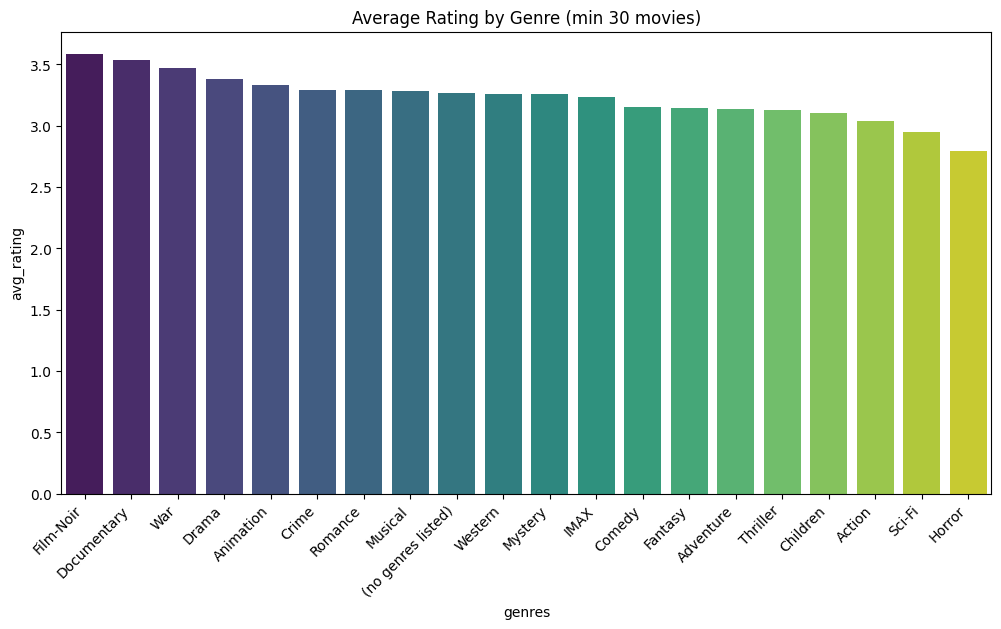

In [38]:
# Step 1: Split genres into lists
df1_exploded = df1.copy()
df1_exploded['genres'] = df1_exploded['genres'].str.split('|')

# Step 2: Explode so each genre gets its own row
df1_exploded = df1_exploded.explode('genres')

# Step 3: Group and analyze
genre_ratings = df1_exploded.groupby('genres')['avg_rating'].mean().reset_index()
genre_counts = df1_exploded.groupby('genres').size().reset_index(name='movie_count')

# Merge both stats
genre_stats = genre_ratings.merge(genre_counts, on='genres')
genre_stats = genre_stats[genre_stats['movie_count'] >= 30]  # filter rare genres
genre_stats = genre_stats.sort_values('avg_rating', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=genre_stats, x='genres', y='avg_rating', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Average Rating by Genre (min 30 movies)")
plt.show()

<Axes: xlabel='genres'>

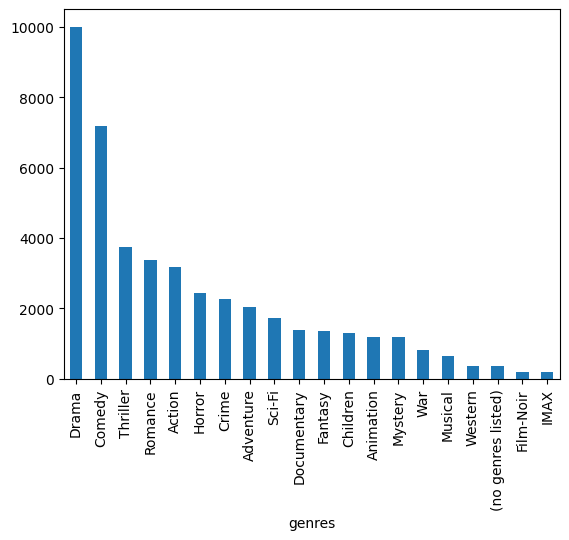

In [39]:
df1_exploded.value_counts('genres').plot(kind = 'bar')

## 🎬 Hybrid Recommender System

This section implements a **Hybrid Movie Recommendation Engine** that combines **User–User Collaborative Filtering** with a **Matrix Factorization (SVD) fallback**, designed for both accuracy and robustness.

### 1️⃣ Goal
Provide personalized movie recommendations to a target user by  
- **Primarily** leveraging patterns of similar users (neighborhood-based filtering).  
- **Fallback** to a latent-factor model (SVD) if sufficient neighborhood information is unavailable.

### 2️⃣ User–User Similarity Layer
* **User–Item Matrix**: Creates a pivot table of users vs. movie ratings.  
* **Cosine Similarity**: Measures similarity between users’ rating vectors.  
* **Minimum Overlap & Thresholding**  
  * Considers only neighbors with **≥ 5 common movies** and **similarity > 0.5**.  
  * Ensures meaningful overlap, avoiding spurious matches when a user has rated only a few movies.
* **Shrinkage Adjustment (Netflix-style)**  
  * Adjusted similarity is calculated as  
    ```
    adjusted_sim = (overlap / (overlap + 10)) * similarity
    ```  
  * Reduces the effect of high similarity from very small overlaps—an industry best practice.
* **Top-Neighbor Selection**: Ranks valid neighbors by adjusted similarity and selects the top 5.

### 3️⃣ Generating Recommendations
* From these top neighbors:
  * Aggregates their ratings with weighted averages by adjusted similarity.
  * Filters out movies the target user has already watched.
  * Enhances ranking by:
    - **Predicted score** (weighted rating)  
    - **Genre overlap** with the user’s historical preferences  
    - **Average movie rating** across all users.

### 4️⃣ SVD Fallback
If no neighbors satisfy the overlap/similarity criteria:
* Applies **Singular Value Decomposition** on the full rating matrix.
* Predicts the target user’s ratings for unseen movies.
* Selects the top 5 highest-predicted titles.

### 5️⃣ Output
For a given `target_user_id`, the system displays:
* Movies already watched by the user.
* Recommended movies with predicted scores, genres, and average ratings.
* The **method used** — “User–User Hybrid” or “SVD Fallback”.

### 6️⃣ Key Advantages
* **Robustness**: Seamless fallback ensures recommendations for cold-start or sparse users.
* **Industry Practices**: Incorporates Netflix-style shrinkage and a hybrid design.
* **Personalization**: Balances collaborative insights (neighborhood) with global patterns (SVD).


In [40]:
df1 = df1_merged

In [41]:
# Hybrid recommender: user-user (with shrinkage & overlap) then SVD fallback
# Dependencies: pandas, numpy, scipy, sklearn (all available in Colab)
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------
# 0) Prepare engine from DF (do once)
# -------------------------
def build_engine(df,
                 user_col='userId', item_col='movieId', rating_col='rating',
                 title_col='title', genres_col='genres', avg_col='avg_rating', review_col='review_count'):
    """
    Build sparse rating matrix R (users x items) and metadata lookups.
    Returns engine dict used by recommend function.
    """
    # ensure stable ordering
    users = np.sort(df[user_col].unique())
    items = np.sort(df[item_col].unique())

    user_to_idx = {u: i for i, u in enumerate(users)}
    idx_to_user = {i: u for u, i in user_to_idx.items()}
    item_to_idx = {it: j for j, it in enumerate(items)}
    idx_to_item = {j: it for it, j in item_to_idx.items()}

    rows = df[user_col].map(user_to_idx).to_numpy(dtype=np.int32)
    cols = df[item_col].map(item_to_idx).to_numpy(dtype=np.int32)
    data = df[rating_col].to_numpy(dtype=np.float32)

    R = csr_matrix((data, (rows, cols)), shape=(len(users), len(items))).tocsr()
    B = R.copy()
    B.data = np.ones_like(B.data)  # binary interactions

    # items metadata keyed by movieId
    items_df = df[[item_col, title_col, genres_col, avg_col, review_col]].drop_duplicates(item_col).set_index(item_col)

    engine = {
        'R': R,
        'B': B,
        'user_to_idx': user_to_idx,
        'idx_to_user': idx_to_user,
        'item_to_idx': item_to_idx,
        'idx_to_item': idx_to_item,
        'items_df': items_df
    }
    return engine

# -------------------------
# 1) User-user neighbor finder
# -------------------------
def find_neighbors(target_user_id, engine,
                   sim_threshold=0.5, min_common=5, shrinkage=10, top_k_candidates=200, top_neighbors=5):
    """
    Find neighbors for the target user satisfying:
      - raw cosine similarity >= sim_threshold
      - overlap >= min_common
    Return: list of tuples (neighbor_user_id, adjusted_similarity, overlap) sorted by adjusted_similarity desc
    """
    R = engine['R']
    B = engine['B']
    user_to_idx = engine['user_to_idx']
    idx_to_user = engine['idx_to_user']

    if target_user_id not in user_to_idx:
        return []

    uidx = user_to_idx[target_user_id]
    # if user has no ratings, no neighbors
    if R.getrow(uidx).nnz == 0:
        return []

    # compute cosine of target row vs all users (fast)
    sims = cosine_similarity(R[uidx], R).ravel()  # shape (n_users,)
    sims[uidx] = 0.0

    # compute overlaps vector: number of items both rated
    overlap_vec = B.getrow(uidx).dot(B.T).toarray().ravel()  # shape (n_users,)

    # initial candidates satisfying raw sim & overlap
    candidate_mask = (sims >= sim_threshold) & (overlap_vec >= min_common)
    candidate_idxs = np.where(candidate_mask)[0]
    if candidate_idxs.size == 0:
        return []

    # restrict to top_k_candidates by raw sim to limit work
    if candidate_idxs.size > top_k_candidates:
        top_idx_in_candidates = np.argsort(sims[candidate_idxs])[-top_k_candidates:]
        candidate_idxs = candidate_idxs[top_idx_in_candidates]

    neighbors = []
    for j in candidate_idxs:
        overlap = int(overlap_vec[j])
        sim = float(sims[j])
        # shrinkage adjustment
        adjusted = (overlap / (overlap + shrinkage)) * sim if overlap > 0 else 0.0
        if adjusted > 0:
            neighbors.append((idx_to_user[j], adjusted, overlap))

    # sort by adjusted similarity
    neighbors_sorted = sorted(neighbors, key=lambda x: x[1], reverse=True)
    return neighbors_sorted[:top_neighbors]

# -------------------------
# 2) Recommend from neighbors (correct aggregation)
# -------------------------
def recommend_from_neighbors(target_user_id, engine, neighbors, top_n=5,
                             prefer_avg_weight=0.25, prefer_genre_weight=0.15, base_weight=0.60):
    """
    neighbors: list of (neighbor_user_id, adjusted_sim, overlap)
    Returns DataFrame of top_n recommendations with metadata
    """
    if not neighbors:
        return pd.DataFrame(columns=['movieId','title','predicted_score','base_pred','avg_rating','review_count','genres'])

    R = engine['R']
    items_df = engine['items_df']
    item_to_idx = engine['item_to_idx']
    idx_to_item = engine['idx_to_item']
    user_to_idx = engine['user_to_idx']

    # target seen movies (indices)
    uidx = user_to_idx[target_user_id]
    seen_cols = set(R.getrow(uidx).indices.tolist())

    # neighbor similarity mapping for quick lookup
    neighbor_sim = {n_uid: sim for (n_uid, sim, ov) in neighbors}

    # aggregate weighted sums
    agg_num = {}   # col_idx -> numerator sum(sim * rating)
    agg_den = {}   # col_idx -> denom sum(sim)
    for n_uid, sim in neighbor_sim.items():
        nidx = user_to_idx.get(n_uid)
        if nidx is None:
            continue
        row = R.getrow(nidx)
        for col, rating in zip(row.indices, row.data):
            if col in seen_cols:
                continue
            agg_num[col] = agg_num.get(col, 0.0) + sim * float(rating)
            agg_den[col] = agg_den.get(col, 0.0) + float(sim)

    if not agg_num:
        return pd.DataFrame(columns=['movieId','title','predicted_score','base_pred','avg_rating','review_count','genres'])

    preds = []
    # build target user genre set
    watched_item_ids = [idx_to_item[c] for c in seen_cols]
    target_genre_set = set()
    for mid in watched_item_ids:
        if mid in items_df.index:
            g = items_df.at[mid, 'genres']
            if pd.notna(g):
                target_genre_set.update(str(g).split('|'))

    # normalization for avg_rating: min-max in items_df
    avg_ratings = items_df['avg_rating'].fillna(0.0)
    min_avg, max_avg = avg_ratings.min(), avg_ratings.max()
    def norm_avg(x):
        if max_avg == min_avg:
            return 0.0
        return (x - min_avg) / (max_avg - min_avg)

    for col_idx, num in agg_num.items():
        den = agg_den.get(col_idx, 1e-9)
        base_pred = num / den
        movie_id = idx_to_item[col_idx]
        if movie_id in items_df.index:
            row = items_df.loc[movie_id]
            avg = float(row['avg_rating']) if pd.notna(row['avg_rating']) else 0.0
            rc = int(row['review_count']) if 'review_count' in items_df.columns and pd.notna(row['review_count']) else 0
            title = row['title']
            genres = row['genres'] if 'genres' in items_df.columns else ''
        else:
            avg = 0.0; rc = 0; title = str(movie_id); genres = ''

        # genre similarity (Jaccard-like)
        movie_genres = set(str(genres).split('|')) if genres and pd.notna(genres) else set()
        if target_genre_set and movie_genres:
            intersection = len(movie_genres & target_genre_set)
            union = len(movie_genres | target_genre_set)
            genre_sim = intersection / union if union > 0 else 0.0
        else:
            genre_sim = 0.0

        final_score = (base_weight * base_pred) + (prefer_avg_weight * norm_avg(avg)) + (prefer_genre_weight * genre_sim)
        preds.append({
            'movie_col': col_idx,
            'movieId': int(movie_id),
            'title': title,
            'base_pred': base_pred,
            'predicted_score': final_score,
            'avg_rating': avg,
            'review_count': rc,
            'genres': genres
        })

    preds_df = pd.DataFrame(preds).sort_values('predicted_score', ascending=False)
    preds_df = preds_df.drop_duplicates(subset='movieId').head(top_n).reset_index(drop=True)
    return preds_df[['movieId','title','predicted_score','base_pred','avg_rating','review_count','genres']]

# -------------------------
# 3) SVD fallback (centered, safe k)
# -------------------------
def svd_fallback(target_user_id, engine, top_n=5, k=50):
    """
    Demean per-user, run svds on sparse R, reconstruct predictions for target user.
    """
    R = engine['R']
    user_to_idx = engine['user_to_idx']
    idx_to_item = engine['idx_to_item']
    items_df = engine['items_df']

    if target_user_id not in user_to_idx:
        return pd.DataFrame(columns=['movieId','title','predicted_score','avg_rating','genres'])

    n_users, n_items = R.shape
    k_safe = min(k, min(n_users, n_items) - 2)
    if k_safe <= 0:
        k_safe = 1

    # compute user means on nonzero entries
    user_sum = np.array(R.sum(axis=1)).ravel()
    user_counts = np.diff(R.indptr)  # number of nonzeros per row
    user_means = np.divide(user_sum, user_counts, out=np.zeros_like(user_sum), where=user_counts>0)

    R_d = R.copy().astype(np.float32)
    rows = R_d.nonzero()[0]
    R_d.data = R_d.data - user_means[rows]  # subtract mean from nonzero entries

    # truncated SVD
    try:
        U, s, Vt = svds(R_d, k=k_safe)
    except Exception as e:
        # fallback to small k
        k_safe2 = min(20, min(n_users, n_items)-2)
        U, s, Vt = svds(R_d, k=k_safe2)

    S = np.diag(s)
    R_hat = (U @ S) @ Vt  # users x items (dense)
    # add means back
    R_pred = R_hat + user_means.reshape(-1, 1)

    uid = user_to_idx[target_user_id]
    row_pred = R_pred[uid, :]

    # mask seen items
    seen_cols = set(R.getrow(uid).indices.tolist())
    row_pred[list(seen_cols)] = -np.inf

    top_idx = np.argpartition(row_pred, -top_n)[-top_n:]
    top_idx = top_idx[np.argsort(row_pred[top_idx])[::-1]]

    recs = []
    for col in top_idx:
        mid = int(idx_to_item[col])
        predicted = float(row_pred[col])
        if mid in items_df.index:
            title = items_df.at[mid, 'title']
            genres = items_df.at[mid, 'genres'] if 'genres' in items_df.columns else ''
            avg = items_df.at[mid, 'avg_rating'] if 'avg_rating' in items_df.columns else np.nan
            rc = items_df.at[mid, 'review_count'] if 'review_count' in items_df.columns else 0
        else:
            title = str(mid); genres=''; avg=np.nan; rc=0
        recs.append({'movieId': mid, 'title': title, 'predicted_score': predicted, 'avg_rating': avg, 'genres': genres, 'review_count': rc})

    return pd.DataFrame(recs).sort_values('predicted_score', ascending=False).reset_index(drop=True)

# -------------------------
# 4) Hybrid wrapper
# -------------------------
def hybrid_recommend(df, target_user_id,
                     sim_threshold=0.5, min_common=5, shrinkage=10,
                     top_neighbors=5, top_n=5, svd_k=50):
    """
    Build engine, try user-user then fallback to svd.
    Returns (watched_df, recs_df, method_used).
    """
    engine = build_engine(df)
    neighbors = find_neighbors(target_user_id, engine,
                               sim_threshold=sim_threshold, min_common=min_common,
                               shrinkage=shrinkage, top_neighbors=top_neighbors)

    if neighbors:
        recs = recommend_from_neighbors(target_user_id, engine, neighbors, top_n=top_n)
        if not recs.empty:
            method = 'user-user'
            # watched movies
            watched_ids = [engine['idx_to_item'][c] for c in engine['R'].getrow(engine['user_to_idx'][target_user_id]).indices.tolist()]
            watched = df[df['movieId'].isin(watched_ids)][['movieId','title']].drop_duplicates().reset_index(drop=True)
            return watched, recs, method

    # fallback
    recs = svd_fallback(target_user_id, engine, top_n=top_n, k=svd_k)
    method = 'svd-fallback'
    watched_ids = []
    if target_user_id in engine['user_to_idx']:
        watched_ids = [engine['idx_to_item'][c] for c in engine['R'].getrow(engine['user_to_idx'][target_user_id]).indices.tolist()]
    watched = df[df['movieId'].isin(watched_ids)][['movieId','title']].drop_duplicates().reset_index(drop=True)
    return watched, recs, method

# -------------------------
# Example usage:
# -------------------------
# set DF = df1_merged (your merged DataFrame)
# watched_df, recs_df, used = hybrid_recommend(DF, target_user_id=10, sim_threshold=0.5, min_common=5, shrinkage=10, top_neighbors=5, top_n=5, svd_k=50)
# print("System used:", used)
# display("Watched:", watched_df)
# display("Recommendations:", recs_df)


In [43]:
usernum = 18
watched_df, recs_df, used = hybrid_recommend(df1, target_user_id= usernum, sim_threshold=0.55, min_common=5, shrinkage=10, top_neighbors=5, top_n=5, svd_k=50)
print("System used:", used)
display(f"Movies Watched by user: {usernum}", watched_df.head(10))
display("Recommendations:", recs_df)

System used: user-user


'Movies Watched by user: 18'

,movieId,title
0,1,Toy Story (1995)
1,3,Grumpier Old Men (1995)
2,5,Father of the Bride Part II (1995)
3,7,Sabrina (1995)
4,10,GoldenEye (1995)
5,11,"American President, The (1995)"
6,17,Sense and Sensibility (1995)
7,19,Ace Ventura: When Nature Calls (1995)
8,47,Seven (a.k.a. Se7en) (1995)
9,50,"Usual Suspects, The (1995)"


'Recommendations:'

,movieId,title,predicted_score,base_pred,avg_rating,review_count,genres
0,2324,Life Is Beautiful (La Vita è bella) (1997),3.238889,5.0,4.2,955,Comedy|Drama|Romance|War
1,318,"Shawshank Redemption, The (1994)",3.233333,5.0,4.4,3330,Crime|Drama
2,1221,"Godfather: Part II, The (1974)",3.227778,5.0,4.3,1357,Crime|Drama
3,48516,"Departed, The (2006)",3.225000,5.0,4.1,979,Crime|Drama|Thriller
4,1089,Reservoir Dogs (1992),3.225000,5.0,4.1,1336,Crime|Mystery|Thriller


In [49]:
from IPython.display import display, HTML

usernum = 18
watched_df, recs_df, used = hybrid_recommend(
    df1,
    target_user_id=usernum,
    sim_threshold=0.55,
    min_common=5,
    shrinkage=10,
    top_neighbors=5,
    top_n=5,
    svd_k=50
)

# ✅ Round selected numeric columns to 1 decimal place for display
numeric_cols = ['predicted_score', 'base_pred', 'avg_rating', 'review_count']
for col in numeric_cols:
    if col in recs_df.columns:
        recs_df[col] = recs_df[col].round(1)

# Title block
print(f"🎬 **Hybrid Recommendation Results for User {usernum}**")
print(f"🔎 Recommendation Engine Used: **{used}**\n")

# Movies Watched
display(HTML("<h4>📽 Movies Already Watched (Random 10)</h4>"))
display(
    watched_df.sample(10)
    .style.set_table_styles(
        [{'selector': 'th',
          'props': [('background-color', '#4CAF50'), ('color', 'white')]}]
    )
    .hide(axis='index')
)

# Recommended Movies with nicely formatted decimals
display(HTML("<h4>✨ Top 5 Recommended Movies</h4>"))
display(
    recs_df
    .style.format({col: "{:.1f}".format for col in recs_df.select_dtypes(float).columns})
    .set_table_styles(
        [{'selector': 'th',
          'props': [('background-color', '#FF9800'), ('color', 'white')]}]
    )
    .hide(axis='index')
)


🎬 **Hybrid Recommendation Results for User 18**
🔎 Recommendation Engine Used: **user-user**



movieId,title
2706,American Pie (1999)
8827,"Bill Cosby, Himself (1983)"
1610,"Hunt for Red October, The (1990)"
4270,"Mummy Returns, The (2001)"
5378,Star Wars: Episode II - Attack of the Clones (2002)
3101,Fatal Attraction (1987)
4720,"Others, The (2001)"
410,Addams Family Values (1993)
1101,Top Gun (1986)
3499,Misery (1990)


movieId,title,predicted_score,base_pred,avg_rating,review_count,genres
2324,Life Is Beautiful (La Vita è bella) (1997),3.2,5.0,4.2,955,Comedy|Drama|Romance|War
318,"Shawshank Redemption, The (1994)",3.2,5.0,4.4,3330,Crime|Drama
1221,"Godfather: Part II, The (1974)",3.2,5.0,4.3,1357,Crime|Drama
48516,"Departed, The (2006)",3.2,5.0,4.1,979,Crime|Drama|Thriller
1089,Reservoir Dogs (1992),3.2,5.0,4.1,1336,Crime|Mystery|Thriller


# **Conclusion**
In this project :

*   Cleaned and merged MovieLens data and explored key trends.  
*   Built a hybrid recommender with **user–user filtering + shrinkage** and an **SVD fallback**.


**Key Takeaways:**

*   Shrinkage improved reliability when user overlap was low, reflecting Netflix’s own practices.
*   The hybrid design produced stable recommendations even for sparse users.
This demonstrates how combining neighborhood-based and latent factor approaches yields a scalable, accurate recommender.



